In [1]:
import json
from io import StringIO
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# ROSBANK

In [2]:
transactions = pd.read_csv('../data/rosbank/train.csv')
transactions['TRDATETIME'] = pd.to_datetime(transactions['TRDATETIME'], format=r'%d%b%y:%H:%M:%S')
transactions = transactions.sort_values(by=['TRDATETIME'])
transactions['hour'] = transactions.TRDATETIME.dt.hour
transactions['day'] = transactions.TRDATETIME.dt.day
transactions['day_of_week'] = transactions.TRDATETIME.dt.day_of_week
transactions['month'] = transactions.TRDATETIME.dt.month
transactions = transactions.rename(columns={'cl_id':'client_id', 'MCC':'small_group', 'amount':'amount_rur'})

In [3]:
transactions.head()

,PERIOD,client_id,small_group,channel_type,currency,TRDATETIME,amount_rur,trx_category,target_flag,target_sum,hour,day,day_of_week,month
26790,01/10/2016,485,4121,type2,810,2016-10-07 00:00:00,242.0,POS,1,85.00,0,7,4,10
72077,01/10/2016,1290,5411,type2,810,2016-10-07 00:00:00,2465.0,POS,1,321242.09,0,7,4,10
26988,01/10/2016,485,6011,type2,810,2016-10-07 00:00:00,3600.0,WD_ATM_PARTNER,1,85.00,0,7,4,10
72068,01/10/2016,1290,6011,type2,810,2016-10-07 18:57:17,10000.0,WD_ATM_ROS,1,321242.09,18,7,4,10
189585,01/10/2016,3351,8999,type3,810,2016-10-08 00:00:00,10000.0,POS,0,0.00,0,8,5,10


In [5]:
transactions['small_group'].value_counts() / len(transactions)

5411    0.247985
6011    0.110868
5814    0.084302
5812    0.061216
5499    0.055528
          ...   
7217    0.000002
3730    0.000002
3051    0.000002
3057    0.000002
3535    0.000002
Name: small_group, Length: 344, dtype: float64

In [68]:
sequences = transactions.groupby('client_id').agg({
    'small_group': lambda x: x.tolist()[:-1],
    'amount_rur':  lambda x: x.tolist(),
    'hour':        lambda x: x.tolist(), 
    'day':         lambda x: x.tolist(), 
    'day_of_week': lambda x: x.tolist(), 
    'month':       lambda x: x.tolist(), 
})
label = transactions.groupby('client_id').agg({
    'small_group': lambda x: x.tolist()[-1]
}).rename(columns={'small_group':'target_flag'})
sequences = sequences.join(label)
mask = sequences['small_group'].apply(lambda x: len(x)) > 5
sequences[mask]

,small_group,amount_rur,hour,day,day_of_week,month,target_flag
client_id,,,,,,,
1,"[5814, 5411, 5814, 5814, 5411, 6011, 5814, 541...","[265.5, 300.0, 399.0, 300.0, 300.0, 50000.0, 3...","[0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[19, 20, 22, 24, 25, 25, 26, 26, 27, 28, 31, 2...","[2, 3, 5, 0, 1, 1, 2, 2, 3, 4, 0, 2, 1, 0, 1, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, ...",5814
5,"[5651, 5813, 5651, 5691, 4722, 5411, 7922, 541...","[13990.0, 280.0, 13990.0, 10773.0, 7244.49, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13,...","[18, 18, 19, 19, 20, 20, 21, 21, 24, 24, 24, 2...","[5, 5, 6, 6, 0, 0, 1, 1, 4, 4, 4, 5, 0, 2, 2, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",5691
9,"[5999, 6011, 6012, 5999, 6011, 6012, 5999, 599...","[5000.0, 5000.0, 87000.0, 100.0, 85000.0, 1174...","[0, 11, 0, 10, 9, 0, 2, 2, 2, 16, 9, 11, 13, 2...","[3, 3, 12, 13, 15, 18, 20, 21, 22, 22, 24, 26,...","[2, 2, 4, 5, 0, 3, 5, 6, 0, 0, 2, 4, 5, 6, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",5999
10,"[5411, 5411, 5541, 5411, 5499, 6011, 6011, 599...","[1317.71, 236.78, 1587.39, 466.25, 314.5, 400....","[0, 0, 0, 0, 0, 6, 7, 8, 8, 0, 0, 0, 14, 0, 0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 0, 1, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",5999
11,"[8062, 5411, 8062, 5999, 5921, 5691, 5712, 541...","[1400.0, 2993.0, 500.0, 502.0, 643.9, 4496.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[23, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 2...","[4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...",5812
...,...,...,...,...,...,...,...
10210,"[5814, 5411, 5200, 5200, 5200, 5200, 5814, 549...","[744.0, 568.0, 1766.0, 87.5, 1498.0, 1963.5, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...","[20, 26, 27, 27, 27, 27, 27, 7, 7, 7, 7, 8, 9,...","[3, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 2, 2, 2, ...","[10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 1...",5499
10212,"[5712, 5712, 5712, 6011, 5712, 6011, 6011, 601...","[50000.0, 26000.0, 50000.0, 50000.0, 29500.0, ...","[0, 0, 0, 13, 0, 10, 10, 10, 0, 9, 9, 9, 0, 0]","[10, 15, 13, 13, 15, 15, 15, 15, 29, 29, 29, 2...","[2, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]","[5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7]",5712
10213,"[6012, 6011, 5411, 5411, 5411, 6011, 5411, 541...","[40000.0, 6000.0, 22408.8, 11500.0, 22494.2, 3...","[20, 0, 0, 0, 0, 8, 0, 0, 0, 7, 0, 0, 8, 8, 0,...","[11, 12, 13, 14, 20, 20, 21, 24, 24, 24, 26, 4...","[1, 2, 3, 4, 3, 3, 4, 0, 0, 0, 2, 3, 3, 3, 2, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, ...",5411


In [70]:
sequences.shape, sequences[mask].shape

((5000, 7), (4755, 7))

In [67]:
mask = sequences['small_group'].apply(lambda x: len(x)) > 5
mask

client_id
0        False
1         True
5         True
9         True
10        True
         ...  
10210     True
10212     True
10213     True
10214     True
10215     True
Name: small_group, Length: 5000, dtype: bool

# Tinkoff

In [29]:
df_customer_train = pd.read_csv('../data/tinkoff/customer_train.csv')
df_stories_description = pd.read_csv('../data/tinkoff/stories_description.csv')
df_transactions = pd.read_csv('../data/tinkoff/transactions.csv')

In [30]:
example_story = json.load(StringIO(df_stories_description.iloc[0]['story_json']))

In [31]:
example_story.keys()

dict_keys(['guid', 'type', 'description', 'properties', 'content'])

In [32]:
df_transactions

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
0,855115,7,3,1500,4554547,5411
1,997036,6,6,0,1657528,5411
2,398237,5,24,2500,26375569,5813
3,997036,6,2,0,16304402,5411
4,291636,7,25,0,1259505,5411
...,...,...,...,...,...,...
3951110,153986,6,30,29500,92701772,5719
3951111,346407,6,18,500,120278116,4816
3951112,358612,6,6,2500,111686898,5691
3951113,346407,6,7,500,2765037,5411


In [33]:
df_transactions[['transaction_amt', 'merchant_mcc']].describe()

,transaction_amt,merchant_mcc
count,3.951115e+06,3.951115e+06
mean,9.767657e+02,5.584733e+03
std,4.674880e+03,7.599550e+02
min,0.000000e+00,1.520000e+03
25%,0.000000e+00,5.411000e+03
50%,5.000000e+02,5.499000e+03
75%,5.000000e+02,5.814000e+03
max,1.854500e+06,9.405000e+03


Обратил внимание, что очень много транзакций с суммой перевода равной нулю

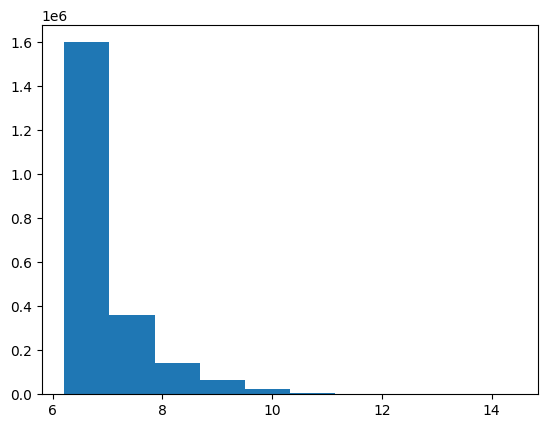

In [34]:
plt.hist(np.log(df_transactions[df_transactions['transaction_amt'] != 0]['transaction_amt']));

In [35]:
df_transactions[df_transactions['transaction_amt'] == 0]['transaction_amt'].count()

1751628

In [36]:
df_transactions[df_transactions['transaction_amt'] == 0]

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
1,997036,6,6,0,1657528,5411
3,997036,6,2,0,16304402,5411
4,291636,7,25,0,1259505,5411
7,862192,7,14,0,65419694,5814
8,862192,5,26,0,97570081,5411
...,...,...,...,...,...,...
3951098,289468,6,2,0,77187702,4121
3951099,603825,6,4,0,77187702,4121
3951102,561987,7,8,0,77187702,4121
3951103,561987,7,1,0,7653547,5499


Так как у нас нет никого описания датасета, предположим, что это NaN транзакции и просто дропнем их

In [37]:
df_transactions.drop(
    index=df_transactions[df_transactions['transaction_amt'] == 0].index,
    axis=1,
    inplace=True
)

In [38]:
df_transactions['TRDATETIME'] = \
    df_transactions[['transaction_month', 'transaction_day']].apply(
        lambda x: '.'.join(chain(('2020',), map(str, x))),
        axis=1
    )
df_transactions['TRDATETIME'] = pd.to_datetime(
    df_transactions['TRDATETIME'], format='%Y.%m.%d'
)
df_transactions.drop(columns=['transaction_month', 'transaction_day', 'merchant_id'], axis=1, inplace=True)

In [39]:
df_transactions

,customer_id,transaction_amt,merchant_mcc,TRDATETIME
0,855115,1500,5411,2020-07-03
2,398237,2500,5813,2020-05-24
5,844503,3500,5411,2020-05-24
6,844503,3500,5411,2020-06-22
14,408749,1500,5211,2020-06-12
...,...,...,...,...
3951110,153986,29500,5719,2020-06-30
3951111,346407,500,4816,2020-06-18
3951112,358612,2500,5691,2020-06-06
3951113,346407,500,5411,2020-06-07


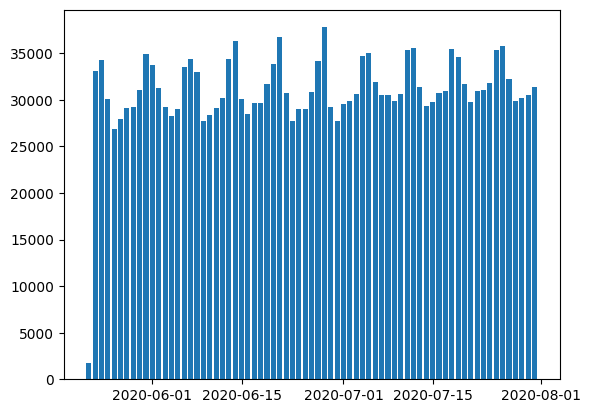

In [40]:
data = df_transactions.groupby('TRDATETIME')['transaction_amt'].count()

plt.bar(data.index, data);

# Gender

In [41]:
df_tr_types = pd.read_csv('../data/gender/tr_types.csv', sep=';')
df_tr_mcc_codes = pd.read_csv('../data/gender/tr_mcc_codes.csv', sep=';')
df_transactions = pd.read_csv('../data/gender/transactions.csv')

In [42]:
df_transactions

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...,...
6849341,61870738,453 16:03:02,5499,1010,-5176.84,10217113
6849342,61870738,454 10:54:60,5411,1010,-1652.77,022915
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124


In [76]:
df_tr_types[df_tr_types['tr_type'] == 1010]

,tr_type,tr_description
98,1010,Покупка. POS ТУ СБ РФ


In [88]:
def convert_to_daytime(series: pd.Series):
    datetime_strange_format: str = series[0]
    day, time = datetime_strange_format.split(' ')
    day = int(day)
    day += 1

    if day <= 365:
        year = '2017'
    else:
        day -= 365
        year = '2018'
    return f'{year}-{day} {time}'

In [93]:
df_transactions['TRDATETIME'] = \
    df_transactions[['tr_datetime']].apply(
        convert_to_daytime,
        axis = 1
    )
df_transactions['TRDATETIME'] = pd.to_datetime(
    df_transactions['TRDATETIME'],
    format='%Y-%j %H:%M:%S'
)

df_transactions.drop(columns='tr_datetime', axis=1, inplace=True)

In [94]:
df_transactions

,customer_id,mcc_code,tr_type,amount,term_id,TRDATETIME
0,39026145,4814,1030,-2245.92,NaN,2017-01-01 10:23:26
1,39026145,6011,7010,56147.89,NaN,2017-01-02 10:19:29
2,39026145,4829,2330,-56147.89,NaN,2017-01-02 10:20:56
3,39026145,5499,1010,-1392.47,NaN,2017-01-02 10:39:54
4,39026145,5499,1010,-920.83,NaN,2017-01-03 15:33:42
...,...,...,...,...,...,...
6849341,61870738,5499,1010,-5176.84,10217113,2018-03-30 16:03:02
6849342,61870738,5411,1010,-1652.77,022915,2018-03-31 10:55:00
6849343,61870738,5499,1010,-4687.23,10217113,2018-03-31 14:23:59
6849344,61870738,5541,1110,-4491.83,RU570124,2018-03-31 16:11:53
